In [2]:
from cgeniepy.ecology import EcoModel
import pandas as pd
from cgeniepy.array import GriddedData
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.colors as colors

arc_mask = xr.load_dataarray("../data/masked_array.nc")

kpg_model = EcoModel('../model/muffin.u067bc.PO4Fe.main', gemflag=['biogem', 'ecogem'])

def ocn_var_mean_change(model, variable, anomaly=True, timeslice=[4]):
    if anomaly:
        var0 = model.get_var(variable).isel(time=0).data * arc_mask
        var1 = model.get_var(variable).isel(time=timeslice).mean(dim=['time']).data * arc_mask
        diff = var1 - var0
        return GriddedData(diff, attrs=model.get_var(variable).attrs)
    else:
        var1 = model.get_var(variable).isel(time=timeslice).mean(dim=['time']).data * arc_mask
        return GriddedData(var1, attrs=model.get_var(variable).attrs)
    
##　use Helveticas
plt.rcParams['font.sans-serif'] = "Helvetica"

In [4]:
mld = ocn_var_mean_change(kpg_model, 'phys_MLD', True).to_GriddedDataVis()
poc = ocn_var_mean_change(kpg_model, 'bio_fpart_POC', True).isel(zt=0).to_GriddedDataVis()
ph = ocn_var_mean_change(kpg_model, 'misc_pH', True).to_GriddedDataVis()
omega_cal= ocn_var_mean_change(kpg_model, 'carb_ohm_cal', False).isel(zt=0)
omega_cal.attrs['units'] = 'unitless'
omega_cal = omega_cal.to_GriddedDataVis()
omega_ara = ocn_var_mean_change(kpg_model, 'carb_ohm_arg', False).isel(zt=0)
omega_ara.attrs['units'] = 'unitless'
omega_ara = omega_ara.to_GriddedDataVis()

sst = ocn_var_mean_change(kpg_model, 'ocn_sur_temp', True).to_GriddedDataVis()
po4 = ocn_var_mean_change(kpg_model, 'ocn_sur_PO4', True).to_GriddedDataVis()
fe = ocn_var_mean_change(kpg_model, 'ocn_sur_TDFe', True).to_GriddedDataVis()

In [6]:
import cmcrameri.cm as cmc 
cmap = cmc.vik
cmap2 = cmc.batlow

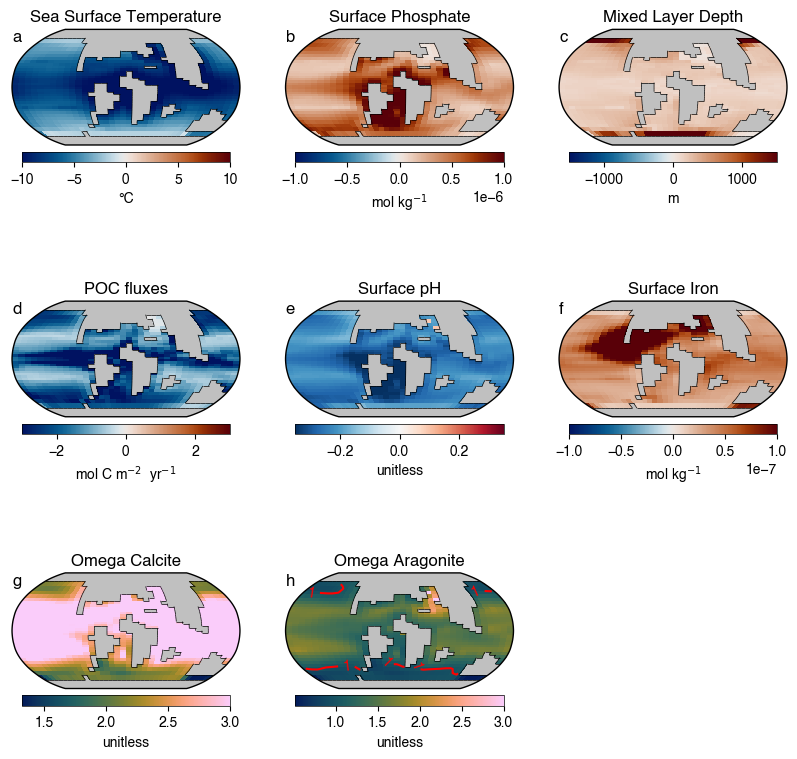

In [11]:
fig, axs = plt.subplots(3,3,figsize=(10, 10), subplot_kw={'projection': ccrs.Robinson()})

sst.aes_dict['pcolormesh_kwargs']['cmap'] = cmap
sst.aes_dict['pcolormesh_kwargs']['norm'] = colors.CenteredNorm(halfrange=10)
sst.aes_dict['colorbar_label_kwargs'] = {'label': '°C'}
sst.plot(ax=axs[0,0], outline=True, colorbar=True)

po4.aes_dict['pcolormesh_kwargs']['cmap'] = cmap
po4.aes_dict['pcolormesh_kwargs']['norm'] = colors.CenteredNorm(halfrange=1E-6)
po4.aes_dict['colorbar_label_kwargs'] = {'label': 'mol kg$^{-1}$'}
po4.plot(ax=axs[0,1], outline=True, colorbar=True)

mld.aes_dict['pcolormesh_kwargs']['cmap'] = cmap
mld.aes_dict['pcolormesh_kwargs']['norm'] = colors.CenteredNorm(halfrange=1500)
mld.aes_dict['colorbar_label_kwargs'] = {'label': 'm'}
mld.plot(ax=axs[0,2], outline=True, colorbar=True)

poc.aes_dict['pcolormesh_kwargs']['cmap'] = cmap
poc.aes_dict['pcolormesh_kwargs']['norm'] = colors.CenteredNorm(halfrange=3)
poc.aes_dict['colorbar_label_kwargs'] = {'label': r'mol C m$^{-2}$  yr$^{-1}$'}
poc.plot(ax=axs[1,0], outline=True, colorbar=True)

ph.aes_dict['pcolormesh_kwargs']['cmap'] = cmap
ph.aes_dict['pcolormesh_kwargs']['norm'] = colors.CenteredNorm(halfrange=0.35)
ph.aes_dict['colorbar_label_kwargs'] = {'label': 'unitless'}
ph.plot(ax=axs[1,1], outline=True, colorbar=True)

fe.aes_dict['pcolormesh_kwargs']['cmap'] = cmap
fe.aes_dict['pcolormesh_kwargs']['norm'] = colors.CenteredNorm(halfrange=1E-7)
fe.aes_dict['colorbar_label_kwargs'] = {'label': 'mol kg$^{-1}$'}
fe.plot(ax=axs[1,2], outline=True, colorbar=True)

omega_cal.aes_dict['pcolormesh_kwargs']['cmap'] = cmap2
omega_cal.aes_dict['pcolormesh_kwargs']['vmax'] = 3
omega_cal.aes_dict['colorbar_label_kwargs'] = {'label': 'unitless'}
omega_cal.aes_dict['contour_kwargs'] = {'levels': [1], 'colors': 'red'}
omega_cal.aes_dict['contour_label_kwargs'] = {'colors': 'red'}
omega_cal.plot(ax=axs[2,0], outline=True, colorbar=True, contour=True)

## add a contour ofr omega
omega_ara.aes_dict['pcolormesh_kwargs']['cmap'] = cmap2
omega_ara.aes_dict['pcolormesh_kwargs']['vmax'] = 3
omega_ara.aes_dict['colorbar_label_kwargs'] = {'label': 'unitless'}
omega_ara.aes_dict['contour_kwargs'] = {'levels': [1], 'colors': 'red'}
omega_ara.aes_dict['contour_label_kwargs'] = {'colors': 'red'}

omega_ara.plot(ax=axs[2,1], outline=True, colorbar=True, contour=True)

## add alphabetic labels for each subplot
for i, ax in enumerate(axs.flat):
    ax.text(0, 1.0, chr(97+i), transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')
    
## add title for each subplot
axs[0,0].set_title('Sea Surface Temperature')
axs[0,1].set_title('Surface Phosphate')
axs[0,2].set_title('Mixed Layer Depth')
axs[1,0].set_title('POC fluxes')
axs[1,1].set_title('Surface pH')
axs[1,2].set_title('Surface Iron')
axs[2,0].set_title('Omega Calcite')
axs[2,1].set_title('Omega Aragonite')

## remove last subplot
fig.delaxes(axs[2,2])
fig.savefig('../output/env_change_map.png', dpi=300, bbox_inches='tight')

In [6]:
# ## export for EXP4/5
# import numpy as np

# ## convert celsius to kelvin
# sst = ocn_var_change(m3, 'ocn_sur_temp', 0)
# sst_kelvin = sst.array.values + 273.15
# ## round to 2 decimal places
# ## replace na with 1E-5
# np.nan_to_num(sst_kelvin, copy=False, nan=1E-5)
# np.savetxt('../data/muffin.u067bc.PO4.SST.txt', sst_kelvin, fmt='%.2f', delimiter='\t')

# #PARfrac * dum_egbg_fxsw(:,:)
# fxsw = ocn_var_change(m3, 'phys_fxsw', 0)
# par_frac = 0.43
# par = fxsw * par_frac

# np.savetxt('../data/muffin.u067bc.PO4.PAR.txt', par.array.values, fmt='%.2f', delimiter='\t')

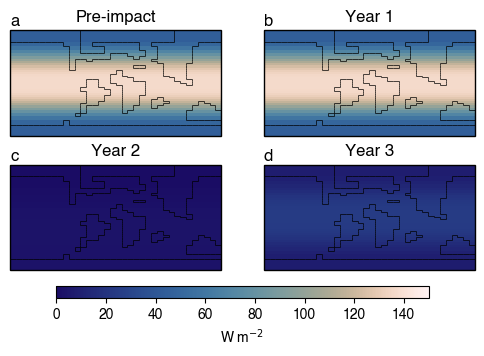

In [ ]:
## plot PAR evolution
par = kpg_model.get_var("phys_fxsw")*0.43

mask = kpg_model.grid_mask()

## plot 1, 2, 3, 4 year
fig, axs = plt.subplots(2,2,figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()})
par1 = par.isel(time=2).to_GriddedDataVis()
par2 = par.isel(time=3).to_GriddedDataVis()
par3 = par.isel(time=4).to_GriddedDataVis()
par4 = par.isel(time=5).to_GriddedDataVis()

## add geography for each subplot
for ax in axs.flat:
    mask.plot(ax=ax, color='black', alpha=0.5, pcolormesh=False, outline=True)

cmap = cmc.lapaz

p = par1.plot(ax=axs[0,0], cmap=cmap, colorbar=False, vmin=0, vmax=150)
par2.plot(ax=axs[0,1], cmap=cmap, colorbar=False, vmin=0, vmax=150)
par3.plot(ax=axs[1,0], cmap=cmap, colorbar=False, vmin=0, vmax=150)
par4.plot(ax=axs[1,1], cmap=cmap, colorbar=False, vmin=0, vmax=150)

axs[0,0].set_title('Pre-impact')
axs[0,1].set_title('Year 1')
axs[1,0].set_title('Year 2')
axs[1,1].set_title('Year 3')


# add alphabetic labels for each subplot
for i, ax in enumerate(axs.flat):
    ax.text(0.0, 1.15, chr(97+i), transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')

 
## add colorbar
cbar = fig.colorbar(p, ax=axs, orientation='horizontal', aspect=30, pad=0.05, shrink=0.8)
cbar.set_label('W m$^{-2}$')
fig.savefig('../output/par_evolution.png', dpi=300, bbox_inches='tight')